# Assignment 2.  Conduct the analysis of a classification problem of cervical cancer (Risk Factors) Data Set.


In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1. Preprocessing

- Read the data using pandas (1 point).
- In both datasets, we have several columns that can be used to design target; see details in the documentation. Please, select a reasonable binary target combining these columns and motivate your selection. You can also select a couple of targets to analyze & compare the performance of ML models within the next steps. Important: don't forget to drop columns directly associated with the selected target (3 points).

In [2]:
# Load the data
data = pd.read_csv('risk_factors_cervical_cancer.csv', na_values='?')

In [3]:
# Here you can see what we have intially
data.head(4)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0


In [4]:
# Filling NaN with median in numerical case and with mode in categorical 
# (this method, IMHO, makes more sence that dropping Nan values or replacing all of them with mean)
# (so I decided to do it that way and don't use SimpleImputer() )
number_type = ["Age","Number of sexual partners","First sexual intercourse","Num of pregnancies","Hormonal Contraceptives (years)","Smokes (years)","Smokes (packs/year)","IUD (years)","STDs (number)","STDs: Number of diagnosis"]
for column in number_type:
        data[column] = data[column].fillna(data[column].median())
        
# At this moment we filled all numerical NaNs so it's categorical columns turn
categorical_type = set(data.columns) - set(number_type)
for column in categorical_type:
        data[column] = data[column].fillna(data[column].mode()[0])   

In [5]:
# I think that this 2 columns have basically no information (based on correlation heatmap before dropping) so I suggest we can drop them
data = data.drop(["STDs:AIDS", "STDs:cervical condylomatosis",], axis = 1)

# To estimate approximate number of people that actually have non-null target columns
# let's create new column - sum of target columns basically. I think it can help in prediction evaluation.
data["Sum_target"]=data["Biopsy"]+data["Hinselmann"]+data["Schiller"]+data["Citology"]

#### Let's look at the new column - the sum of all 4 target features. What the histogram based on this new obtained data can tell us? More than 88% of all patients don't have any target-positive features. From one perspective - this new column is very imbalanced, from another it shows the high ratio of potentially healthy people (since all target values are False) and can be used in validation of the result. I think that this new generated feature itself can serve as a target-feature for our training model, but first I want to use only 'Biopsy' feature as target (it is more obvious than 'sum of every test' even without additional paper research).

Class 0: 756
Class 1: 41
Class 2: 22
Class 3: 33
Class 4: 6
Percentage of people having negative results on all tests: 88.11 %


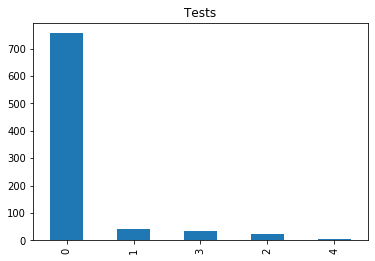

In [6]:
target_count = data.Sum_target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Class 2:', target_count[2])
print('Class 3:', target_count[3])
print('Class 4:', target_count[4])
print('Percentage of people having negative results on all tests:', round(100-(target_count[1]+target_count[2]+target_count[3]+target_count[4]) / (target_count[0]+target_count[1]+target_count[2]+target_count[3]+target_count[4])*100, 2), '%')

target_count.plot(kind='bar', title='Tests');

### 2. Exploratory analysis

Generate three hypotheses related to your problem and try to confirm or deny them using exploratory visualization. Please, try to use different types of plots if possible. (6 points, 2 points for each hypothesis. If you use only one type of plots for all hypotheses -- no more than 4 points for this part)

In [7]:
# At first I want to see both whole correlation picture and correlation with particular feature - our first target (Biopsy)

C = data.corr()
print(C.loc[:, 'Biopsy'])

Age                                   0.055956
Number of sexual partners            -0.000408
First sexual intercourse              0.007259
Num of pregnancies                    0.040215
Smokes                                0.028724
Smokes (years)                        0.061204
Smokes (packs/year)                   0.024487
Hormonal Contraceptives              -0.018015
Hormonal Contraceptives (years)       0.094164
IUD                                   0.059231
IUD (years)                           0.038176
STDs                                  0.114148
STDs (number)                         0.103153
STDs:condylomatosis                   0.090164
STDs:vaginal condylomatosis          -0.017911
STDs:vulvo-perineal condylomatosis    0.092548
STDs:syphilis                        -0.038311
STDs:pelvic inflammatory disease     -0.008940
STDs:genital herpes                   0.130523
STDs:molluscum contagiosum           -0.008940
STDs:HIV                              0.127702
STDs:Hepatiti

#### 1. First hypothesis is intuitive - one of the most obvious cancer-inducing factor in given features is  ̶F̶i̶r̶s̶t̶ ̶s̶e̶x̶u̶a̶l̶ ̶i̶n̶t̶e̶r̶c̶o̶u̶r̶s̶e̶ smoking. Here we have 3 columns represeting this bad habit. I chose  'Smokes (packs/year)' and  'Smokes (years)', because this features, in my opinion, are more informative. Binary 'Smokes' feature can indicate that patient can either smoke 1-2 times a week (or even a month) or smoke 5-6 times a day, the difference is too dramatic. In this section I removed all non-smokers since I've wanted to show the destructive influence of smoking and we have only 123/858 smokers in this dataset (we don't need many useless dots at the zero of Y axis to show that).
#### a) 'Smokes (years)' graph shows that there is indeed a tendence to have positive biopsy test result when smoking period during person's life is in average from 30% to 60% (I also suppose there is no need to draw a  trend line for it) - large gap, but ay least it exists and can be seen (from this picture).

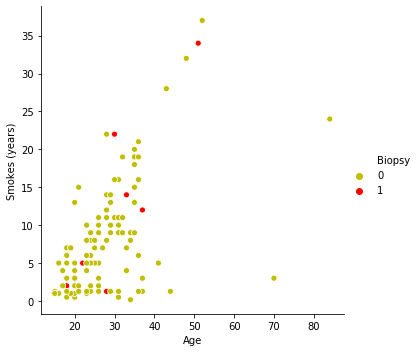

In [8]:
sns.relplot(x="Age", y="Smokes (years)",hue="Biopsy",data= data.loc[data['Smokes (years)'] != 0], palette = ["y", "r"])
plt.show()

#### b) Here we can see that Biopsy-positive tests are localized: there are only 1 patient older than 50 and also only 1 smokes more than 8 packs a year. Thus I assume that duration of smoking in years has more imact on biopsy result than number of packs a year. Interestingly enough there is present kind of age-dependece too, which I want to look at in second hypothesis ( I also tried to create and plot new feature that is multiplication of this columns (kind of packs that patient smoked in total), but result was harder to explain, looked actually similar to the 'p/y' graph).

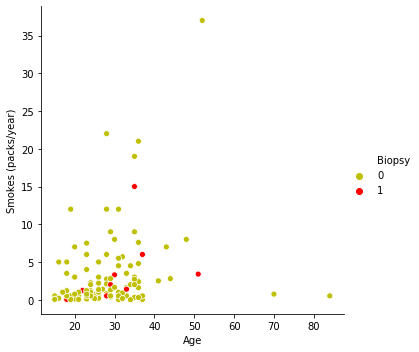

In [9]:
sns.relplot(x="Age", y="Smokes (packs/year)",hue="Biopsy",data= data.loc[data['Smokes (packs/year)'] != 0], palette = ["y", "r"])
plt.show()

#### 2. Second hypothesis. From this plot we clearly can see that positive biopsy test results occure only between ~15 and ~52 years, which is partly can be confirmed by previous cancer diagnostic. Cancer diagnosis were positive in the same age period, so I assume there is defenetely age relation (in this particular type of cancer).

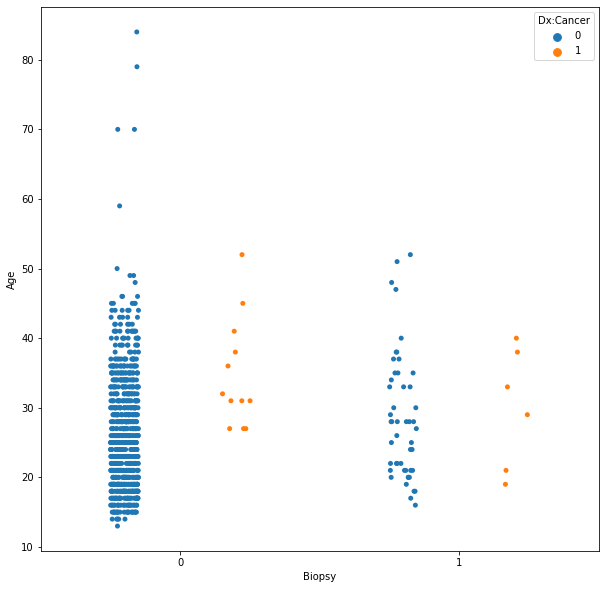

In [10]:
# the age of cancer diagnosis
plt.subplots(figsize=(10,10))
sns.stripplot(x="Biopsy", y="Age", hue="Dx:Cancer", data=data, dodge=True, jitter=True, alpha=1, zorder=1)
plt.show()

#### 3. Third hypothesis. Scientitst are certain that [HPV plays role in cervical cancer development](https://www.mayoclinic.org/diseases-conditions/cervical-cancer/symptoms-causes/syc-20352501), so let's test this hypothesis with our data. These 2 features have relatively high correlation (0.16)  in comparasing with another features and from the graph - it can be seen from heatmap graph below. Previously diagnosed HPV also have high correlations with smoking (p/y) and previously diagnosed cancer. So our correlation graph also helps to prove our proposition. Next we can count the ratio of people previously diagnosed with HPV and having positive biopsy results: neg.biop/pos.bio = 2/1 - relatively high number of people diagnosed with HPV have positive biopsy (thus hypothesis is plausible on this data).

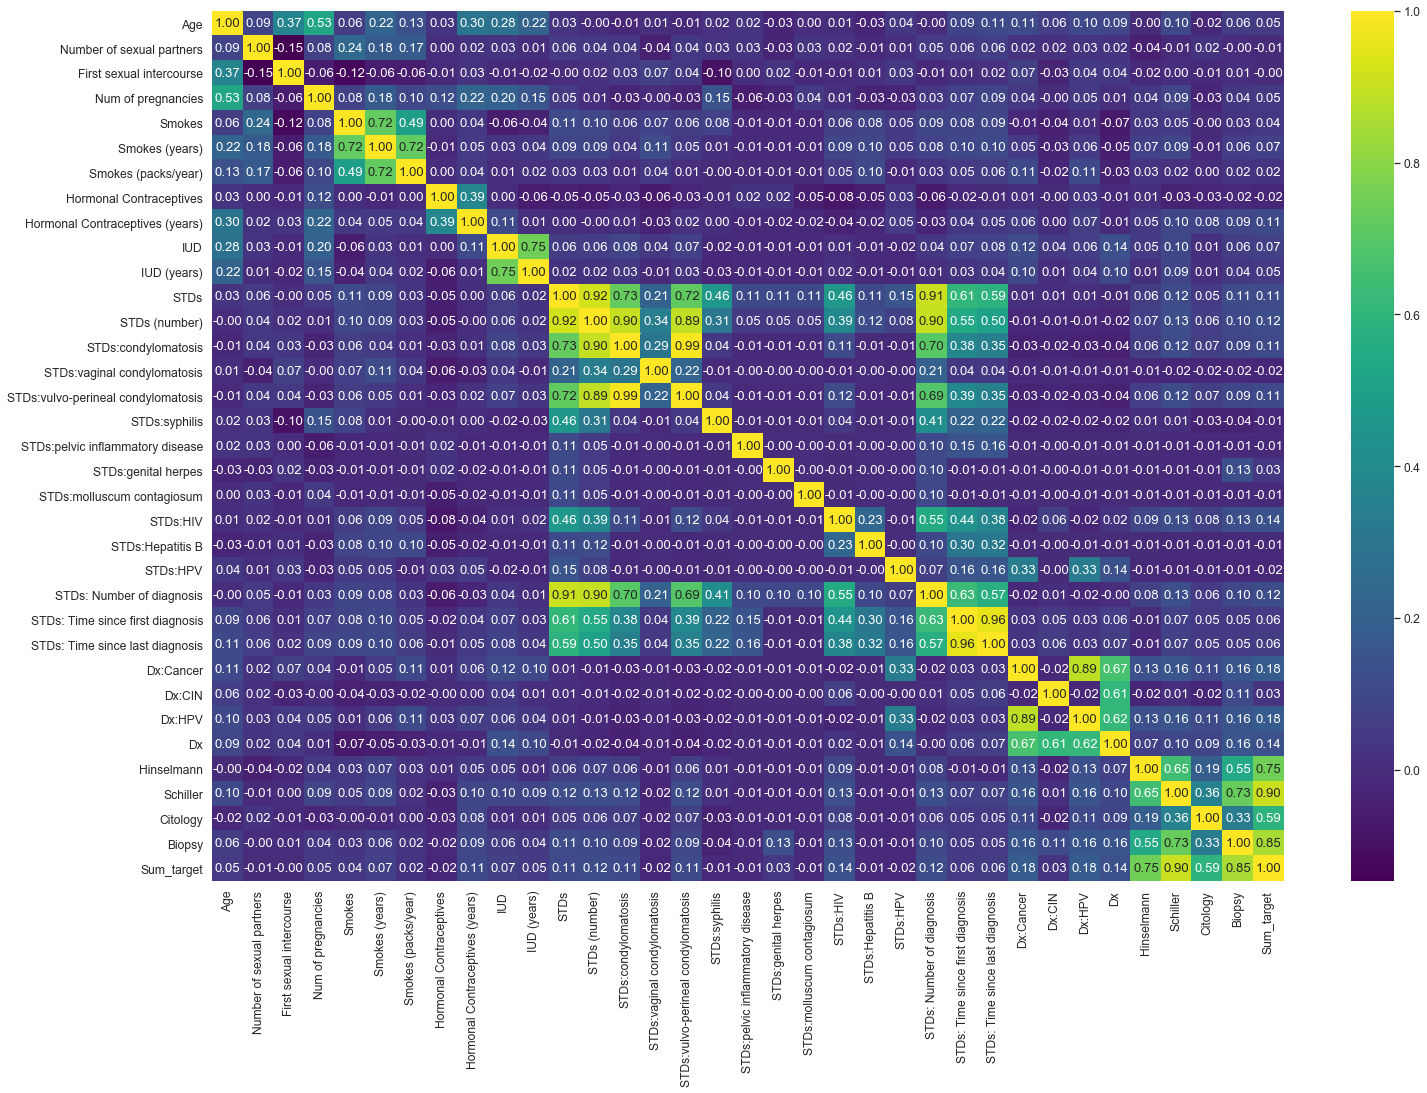

In [11]:
# Let's create truly beautiful graph representing correlations of our data
sns.set(font_scale=1.1)
f, ax = plt.subplots(figsize=(24, 16))
sns.heatmap(C, cmap='viridis', annot=True, ax=ax, fmt='.2f')

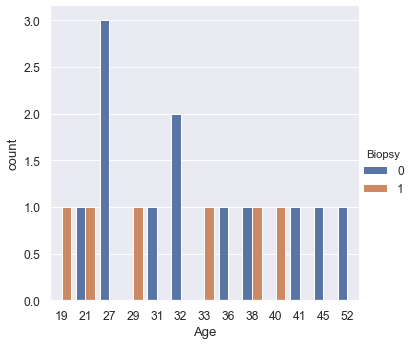

In [12]:
sns.catplot(x="Age", hue="Biopsy",data= data.loc[data['Dx:HPV'] != 0], kind="count")

### 3. Metrics & Validation

- Please, analyze the balance of the target variable (or variables if you decided to work with two output variables). Which quality metrics are suitable for your task? Why? (2 points).
- Split data into train and test sets using train_test_split. Important: if your problem is imbalanced, use stratify parameter.  The test set shouldn't be used for models fitting or selection of the optimal set of parameters (1 point).

Class 0: 803
Class 1: 55
Proportion: 14.6 : 1


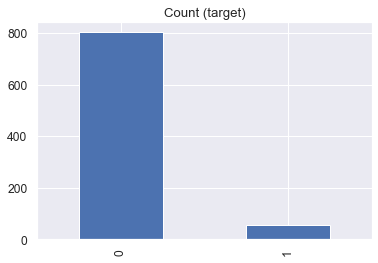

In [13]:
# Biopsy - heavily inbalanced target, the ratio of biopsy-positive/biopsy-negative results is small so stratification is needed
target_count = data.Biopsy.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

#### Since we are working with imbalanced data, we should choose our qualify metric wisely. Mikhail Belyaev gave us great example - in our cervical cancer dataset 88% of patients presumably do not have cancer. So if we will create a very bad model predicting every case as "this person has no cancer" and will use Accuracy, we will classify those 88% non-cancer patients correctly and the Accuracy of such a bad model will be also 88%. So we can use, for example f1 or roc_auc (The precision of a class define how trustable is the result when the model answer that a point belongs to that class. The recall of a class expresses how well the model is able to detect that class. I chose f1 metric, because it seems to be balanced enough for our task according to the documentation - f1 calculates the harmonic mean of the precision and recall). 
#### Thus we can estimate the ability of algorithm to find the class (recall), and the ability to distinguish the elements (precision).

In [14]:
from sklearn.model_selection import train_test_split
y = data["Biopsy"]
# It is strange to use other target variables as features (our "goal",
# as I understand, is to create the predictor based on straight forward
# analysis of real data, not based on another analysis) - I will drop them.

X = data.drop(["Biopsy", "Hinselmann", "Schiller", "Citology", "Sum_target"], axis=1)
# Trying to make data balanced using stratify parameter to be sure 
# that our data will be splitted with the same proportion as the target.
# I'm using 80% of data for training and 20% - for testing. Seed = 42.
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify = y) 
X.shape

(858, 30)

### 4. ML
- Propose appropriate preprocessing steps for your model, for example,
 - use SimpleImputer() if you have missing variables;
 - use OneHotEncoder() if you have categorical variables;
 - use StandardScaler() if you plan to work with a linear method.
- Implement a pipeline to combine the designed preprocessing steps with LogisticRegression (2 points).
- Find a good combination of parameters(penalty type and regularization coefficient C) via cross-validation. Please use the stratified version of KFold if your dataset isn't balanced, see StratifiedKFold() (4 points).
- Refit model with optimal parameters on the whole train set and check the quality of prediction on the test set (1 point).
- Repeat the last step with any tree-based model (Random Forest, GradientBoosting, XGBoost or CatBoost). Use GridSearchCV to identify the optimal set of parameters (at least, try to different reasonable values of  n_estimators and max_depth). Check the quality on the test set  (4 points).
- Plot the dependency of GridSearchCV score on max_depth (see the description (Links to an external site.) of cv_results_ attribute). (2 points).
- In addition to the already calculated metrics, please draw Precision-Recall curves (Links to an external site.) for both linear and tree-based models. Compare models using PR-curves. (2 points).

In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import  StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_recall_curve

#### Let's normalize our data . After that, each feature will should zero mean and variance of 1 (exactly this we can see). This operation needs to be performed on the train data first, and then the same means and variances are to be used to modify the test set. This way we will not introduce any leaks of information about the data in our test set.
#### Since we've already filled all Nan-s, our pipeline will include only scaler.

In [16]:
from sklearn.preprocessing import StandardScaler
# this cell only to show mean and variance, pipeline will be in the next
sc = StandardScaler().fit(X_train)

X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

print("Mean = ",X_train_scaled.mean())
print("Variance = ",X_train_scaled.std())
# We already don't need to fill NaNs, we also have basically nothing to encode, so let's proceed to the next step

Mean =  3.1073297482220124e-18
Variance =  0.983192080250175


In [17]:
# Creating pipeline

pipeline_lg = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced')).fit(X_train, y_train)

c:\users\dg\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
pipeline_lg.fit(X_train, y_train)
print(classification_report(y_test, pipeline_lg.predict(X_test)))

c:\users\dg\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.94      0.83      0.88       161
           1       0.07      0.18      0.10        11

    accuracy                           0.79       172
   macro avg       0.50      0.51      0.49       172
weighted avg       0.88      0.79      0.83       172



#### Score in chosen metrics is 0.1. Let's improve this result!

In [19]:
import warnings
warnings.filterwarnings("ignore")
# I did it because of gigantic number of warnings about changing of the default solver 

C_list =list(i/10. for i in range(1,100))
parameters_lg = {'logisticregression__C': C_list, 'logisticregression__penalty' : ['l2','l1'] }

score = 'f1'
print("Tuning hyper-parameters for %s\n" % score)
Grid_Lg = GridSearchCV(pipeline_lg, parameters_lg, cv= StratifiedKFold().split(X_train, y_train), scoring=score, refit =True).fit(X_train, y_train)
print('Best parameters (Biopsy):', Grid_Lg.best_params_,'\n')

# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#   print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Tuning hyper-parameters for f1

Best parameters (Biopsy): {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'} 



In [20]:
# Let's use our newly estimated parameters for the test set - a.k.a refitting (Biopsy)
best = Grid_Lg.best_estimator_.fit(X_train, y_train)
y_pred = best.predict(X_test)
print("Detailed classification report (Biopsy):")
print(classification_report(y_test, y_pred))


Detailed classification report (Biopsy):
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       161
           1       0.09      0.27      0.14        11

    accuracy                           0.78       172
   macro avg       0.52      0.54      0.50       172
weighted avg       0.89      0.78      0.83       172



In [22]:
y_pred

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

(0.0, 1.0)

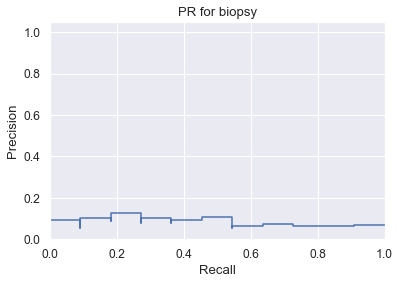

In [122]:
# PR - curve (Biopsy)
 
precision_b, recall_b, _ = precision_recall_curve(y_test, Grid_Lg.predict_proba(X_test)[:,1])


plt.step(recall_b, precision_b, color='b',where='post')
#plt.fill_between(recall_b, precision_b, alpha=0.2, color='b')
plt.title('PR for biopsy')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

#### Score improved - 0.14, let's compare with RandomTreeClassifier.

In [182]:
# Creating pipeline for rfc
pipeline_rf = make_pipeline(StandardScaler(), RandomForestClassifier(class_weight='balanced',random_state=12)).fit(X_train, y_train)

In [183]:
pipeline_rf.fit(X_train, y_train)
print(classification_report(y_test, pipeline_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       161
           1       0.33      0.09      0.14        11

    accuracy                           0.93       172
   macro avg       0.64      0.54      0.55       172
weighted avg       0.90      0.93      0.91       172



#### The score for RandomForestClassifier is 0.14, which is similar to the previous method.

In [184]:
# We have no limitations in choice of the max_depth and n_estimators range.
# But I don't want to overfit my model using big number of trees or large depth values,
# so I made moderate higher bound and started with low values of this parameters
Depth_list = range(1, 10)
parameters_rf = {'randomforestclassifier__max_depth': Depth_list,'randomforestclassifier__n_estimators': range(1, 20)}

Grid_rf = GridSearchCV(pipeline_rf, parameters_rf, cv=StratifiedKFold().split(X_train, y_train), scoring = score)
Grid_rf.fit(X_train, y_train)
print('Best parameters (Biopsy): ',Grid_rf.best_params_)


Best parameters (Biopsy):  {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 7}


In [185]:
# Let's use our parameters for the test set
best = Grid_rf.best_estimator_.fit(X_train, y_train,)
y_pred = best.predict(X_test)
print("Detailed classification report (Biopsy):")
print(classification_report(y_test, y_pred))
f1_score(y_test, y_pred)

Detailed classification report (Biopsy):
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       161
           1       0.17      0.27      0.21        11

    accuracy                           0.87       172
   macro avg       0.56      0.59      0.57       172
weighted avg       0.90      0.87      0.88       172



0.20689655172413793

(0.0, 1.0)

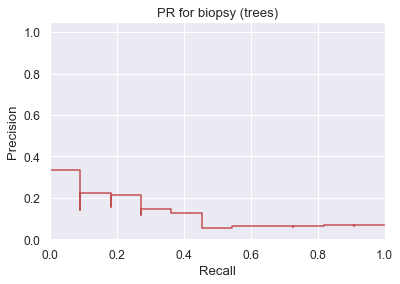

In [186]:
# PR - curve (Biopsy)

precision_rf_b, recall_rf_b, _ = precision_recall_curve(y_test, Grid_rf.predict_proba(X_test)[:,1])

plt.step(recall_rf_b, precision_rf_b, color='r', where='post')
plt.title('PR for biopsy (trees)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

Text(0, 0.5, 'Score')

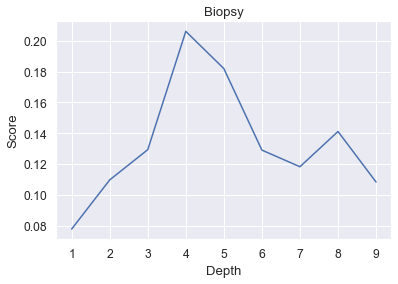

In [174]:
# I choose following plotting strategy - find all values of max_depth corresponding to the best number of estimators and then plot them
data_rf = pd.DataFrame(Grid_rf.cv_results_)
data_rf = data_rf.loc[data_rf['param_randomforestclassifier__n_estimators'] == Grid_rf.best_params_['randomforestclassifier__n_estimators']]

Grid_rf_mean_scores = data_rf.mean_test_score
plt.plot(Depth_list,Grid_rf_mean_scores)
plt.title('Biopsy')
plt.xlabel('Depth')
plt.ylabel('Score')

#### Results from RandomForestClassifier are very inconsistent (I suppose it also has something to do with size of our dataset - it is too small), sometimes it works better (up to 0.21), sometimes a bit worse than logistic regression (0.13). But in general I found that this method slightly outperfoms logistic regession. But in terms of our dataset I think they perform very similar, one is more consistent, another can give slightly better result sometimes. To show particular esult I ysed seed = 12 with score 0.21 (to actually be able to compare results).
#### Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds. Comparasing of the curves is not a difficult task in this case: a red RFC curve is above the  blue LR curve, thus RFC has a better performance level than LR (but both models do poor clasification work which is rather obvious).

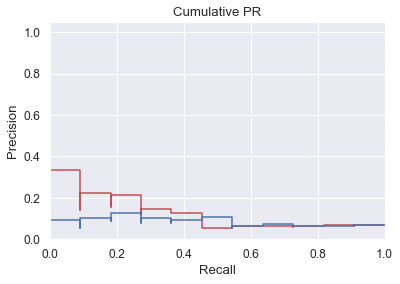

In [187]:
# Cumulative PR plot 
plt.step(recall_rf_b, precision_rf_b, color='r', where='post')
plt.step(recall_b, precision_b, color='b',where='post')
plt.title('Cumulative PR')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

### 5. Conclusion

#### In this mini-project we worked with imbalanced dataset suffering of missing values a lot. Data represents the cervical cancer - one of the most common cancer among women in developing countries, according to WHO. The goal is to predict whether patient has cancer or not based on more than 30 features of given dataset. 
#### Most obvious choice for target value (according to literature) is the biopsy test result. To sum up this column indeed has correlation with "Cancer"/"No cancer" prediction result. Due to large number of missing values, imbalanced data (88% of patients don't have positive result of even 1 out of 4 tests) and size of dataset itself the quality of precision is relatively low (~20% in my case at maximum), but it is at least possible. 
#### Other 3 test-related features also can be used as target features for further analisys(they also have good correlation with biopsy-test), but I think if the dataset will be bigger and more balanced, it will be possible to distinguish different degrees of confidence in cancer diagnosis based on new feature corrensponding cumulative contribution of all 4 tests (weighted, ideally). In our situation quality of even binary classification is not good enough, so we cannot expect much from more complicated model (I've actually tried it with logistic regression but the results were rather bad so I decided not to present such data in the final report. Maybe it was a mistake).
#### As for prediction models, I used Logistic Regression and Random Forest Classifier (with estimation of the best parameters for both models using GridSearchCV), which performed similarly (I mean not excellent) in this task (14% and 21% at max.). Latter was slightly better maybe because of balance of our data and big number of categorical data in this dataset (my assumption) . But overall results are similar.